In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import wandb
plt.style.use('fivethirtyeight')
os.environ["WANDB_QUIET"] = "true"
os.environ["WANDB_NOTEBOOK_NAME"] = "measure_drift.ipynb"

all_data = pd.read_csv('./data/bimbo/train.csv')
all_data.head()

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil
0,3,1110,7,3301,15766,1212,3,25.14,0,0.0,3
1,3,1110,7,3301,15766,1216,4,33.52,0,0.0,4
2,3,1110,7,3301,15766,1238,4,39.32,0,0.0,4
3,3,1110,7,3301,15766,1240,4,33.52,0,0.0,4
4,3,1110,7,3301,15766,1242,3,22.92,0,0.0,3


In [2]:
product_data = all_data.query("Producto_ID == 1238")
product_data.head()

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil
2,3,1110,7,3301,15766,1238,4,39.32,0,0.0,4
95,3,1110,7,3301,198780,1238,9,88.47,0,0.0,9
153,3,1110,7,3301,988589,1238,1,9.83,0,0.0,1
169,3,1110,7,3301,1159580,1238,6,58.98,0,0.0,6
189,3,1110,7,3301,1163700,1238,3,29.49,0,0.0,3


In [3]:
product_data.Semana.value_counts().sort_index()

3    194927
4    181975
5    171431
6    166625
7    164743
8    158032
9    154140
Name: Semana, dtype: int64

In [4]:
store_product_group_cols = ['Agencia_ID', 'Canal_ID', 'Ruta_SAK', 'Cliente_ID']
store_product_value_counts = product_data.groupby(store_product_group_cols).size()
store_product_value_counts.describe()

count    372501.000000
mean          3.199650
std           1.983802
min           1.000000
25%           1.000000
50%           3.000000
75%           5.000000
max           7.000000
dtype: float64

In [5]:
full_filled_cases = (store_product_value_counts == 7)
full_filled_data = product_data.set_index(store_product_group_cols).loc[full_filled_cases]
full_filled_data.reset_index(inplace=True)
original_rows = product_data.shape[0]
new_rows = full_filled_data.shape[0]
frac_data_dropped = 1 - (new_rows / original_rows)
print(f'Went from {original_rows} to {new_rows} rows, removing {(frac_data_dropped*100):.1f}% of rows')

Went from 1191873 to 288617 rows, removing 75.8% of rows


<AxesSubplot:xlabel='Semana'>

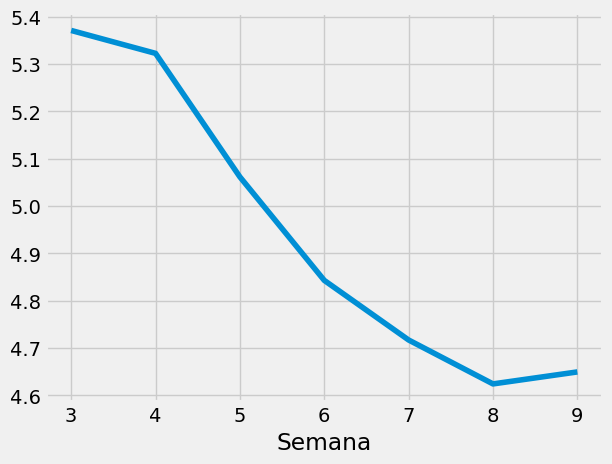

In [6]:
full_filled_data.groupby(['Semana']).Demanda_uni_equil.mean().plot()

In [7]:
wandb_project = "bimbo_drift_check"

run = wandb.init(project=wandb_project, job_type="log_stats")
for semana, mean_demand in full_filled_data.groupby(['Semana']).Demanda_uni_equil.mean().iteritems():
    wandb.log({'week': semana, 'mean_demand': mean_demand})
run.finish()

In [8]:
from utils.time_series_split_modeling import make_models

models, encoder = make_models(full_filled_data)

{'training_data_week': 3, 'validation_data_week': 4, 'validation_loss': 0.49139747695980057}
{'training_data_week': 4, 'validation_data_week': 5, 'validation_loss': 0.5873441757149879}
{'training_data_week': 5, 'validation_data_week': 6, 'validation_loss': 0.39872631840061845}
{'training_data_week': 6, 'validation_data_week': 7, 'validation_loss': 0.2266733422731237}
{'training_data_week': 7, 'validation_data_week': 8, 'validation_loss': 5.725283139814902}
{'training_data_week': 8, 'validation_data_week': 9, 'validation_loss': 0.2880030854521521}
